In [1]:
from DataParser import DataParser
import numpy as np
import pandas as pd
import scipy.sparse as sp

from Base.Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import \
split_train_in_two_percentage_global_sample

from KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from Base.NonPersonalizedRecommender import TopPop
from SLIM_ElasticNet.SLIMElasticNetRecommender import SLIMElasticNetRecommender
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.rcParams.update({'font.size': 40})

%matplotlib inline

In [2]:
seed = 1024
parser = DataParser()

URM_all = parser.get_URM_all()
ICM_all = parser.get_ICM_all()

URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage=0.85, seed=seed)

evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

In [3]:
mat = URM_all.tocoo()
d={'user_id':mat.row,
   'item_id':mat.col,
   'rating':mat.data}
frame = pd.DataFrame(data=d)
frame_n = frame.groupby(['user_id']).size().reset_index(name='num_inter')

In [4]:
#frame_n.loc[frame_n['num_inter'] < 2]

In [57]:
range_all=5
mat = URM_train.tocoo()
d={'user_id':mat.row,
   'item_id':mat.col,
   'rating':mat.data}
frame = pd.DataFrame(data=d)
frame_train = frame.groupby(['user_id']).size().reset_index(name='num_inter')

mat = URM_test.tocoo()
d={'user_id':mat.row,
   'item_id':mat.col,
   'rating':mat.data}
frame_test = pd.DataFrame(data=d)
frame_join = frame_test.join(frame_train.set_index('user_id'), on='user_id')
frame_join = frame_join.loc[frame_join['num_inter'] < 200]
frame_join = frame_join.loc[frame_join['num_inter'] >= 100]

In [6]:
def split_datasets(frame, size = 20):
    max_value = frame['num_inter'].max()
    frame_list=[]
    start_value = 0
    while start_value <= max_value:
        end_value = start_value+size
        sub_frame = frame_join.loc[(frame_join['num_inter'] >= start_value) & (frame_join['num_inter'] < end_value)].iloc[:,:3]
        if not sub_frame.empty:
            t = (start_value, end_value, sub_frame)
        else:
            t = (start_value, end_value, None)
        frame_list.append(t)
        start_value = end_value
    return frame_list

In [7]:
def compute_map_per_range(recommender, URM_test, range_size=20, limit=None):
    map_list=[]
    
    URM_train = recommender.get_URM_train()
    mat = URM_train.tocoo()
    d={'user_id':mat.row,
       'item_id':mat.col,
       'rating':mat.data}
    frame = pd.DataFrame(data=d)
    frame_train = frame.groupby(['user_id']).size().reset_index(name='num_inter')

    mat = URM_test.tocoo()
    d={'user_id':mat.row,
       'item_id':mat.col,
       'rating':mat.data}
    frame_test = pd.DataFrame(data=d)
    frame_join = frame_test.join(frame_train.set_index('user_id'), on='user_id')
    
    frame_list = split_datasets(frame_join, range_size)
    
    for (start_value, end_value, sub_frame) in frame_list[:limit]:
        if sub_frame is None:
            frame_map = None
            frame_len = None
        else:
            frame_len = len(sub_frame.user_id.unique())
            partial_urm_test = sp.csr_matrix((sub_frame.rating, (sub_frame.user_id, sub_frame.item_id)), 
                              shape=URM_train.shape)
            evaluator_test = EvaluatorHoldout(partial_urm_test, cutoff_list=[10])
            result, _ = evaluator_test.evaluateRecommender(recommender)
            frame_map = result[10]['MAP']
        map_list.append((start_value, end_value, frame_map, frame_len))
    
    return map_list
    

In [8]:
def frame_to_plot(map_list):
    x = []
    y = []
    z = []
    for (low, high, val, support) in map_list:
        x_val = str(low)+'-'+str(high)
        if val is None:
            #y.append(0)
            continue
        else:
            y.append(val)
        x.append(x_val)
        z.append(support)
    return x,y,z

In [9]:
def plot_frame(x,y):
    #figure(num=None, figsize=(100, 20), dpi=80, facecolor='w', edgecolor='k')
    #igure(figsize=(50,20))
    axes = plt.gca()
    #axis_font = {'fontname':'Arial', 'size':'22'}
    #axes.set_ylim([0,0.3])
    #axes.tick_params(axis='both', labelsize='large')
    plt.setp(axes.get_xticklabels(), rotation='vertical', fontsize=14)
    
    plt.bar(x, y) #, align='center'
    plt.xticks(range(len(x)), x)

In [10]:
def multiplot_frame(maps, ymax=0.6):
    plt.style.use('seaborn-deep')
    figure(num=None, figsize=(30, 6), dpi=80, facecolor='w', edgecolor='k')
    axes = plt.gca()
    axes.set_ylim([0,ymax])
    clabel= 0
    for x, y in maps:
        plt.bar(range(len(x)), list(y), align='center', label = str(clabel))
        clabel+=1
    plt.legend()
    plt.xticks(range(len(x)), list(list(x)))

In [11]:
def multiplot_frame2(maps, ymax=0.6):
    plt.style.use('seaborn-deep')
    figure(num=None, figsize=(30, 6), dpi=80, facecolor='w', edgecolor='k')
    axes = plt.gca()
    axes.set_ylim([0,ymax])
    clabel= 0
    plt.bar(range(len(maps[0][0])), list(maps[0][1]), align='center')
    clabel+=1
    rects = axes.patches

    # Make some labels.
    labels = maps[0][2]

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        axes.text(rect.get_x() + rect.get_width()/2, height, label, ha='center', va='bottom')
    plt.xticks(range(len(maps[0][0])), list(list(maps[0][0])))

In [13]:
def max_rec_map(maps):
    y_max=[(0,0) for x in range(len(x_cf))]
    c=0
    for _, y in maps:
        for n, val in enumerate(y):
            if val > y_max[n][0]:
                y_max[n] = (val,c)
        c+=1
    y_max,c = zip(*y_max)
    list(y_max)
    c = [x for x in c]
    #fill the name in the same order of appearance in the maps list
    for n in range(len(c)):
        if c[n]==0:
            c[n]='itemCF'
        elif c[n]==1:
            c[n]='itemCBF'
        elif c[n]==2:
            c[n]='PageRankBB'
        elif c[n]==3:
            c[n]='SlimBPR'
        elif c[n]==4:
            c[n]='userCF'
        elif c[n]==5:
            c[n]='PageRankAA'
    c = list(c)
    return y_max, c

In [14]:
rec1 = ItemKNNCBFRecommender(URM_train, ICM_all)
rec1.fit(topK=40, shrink=1000, similarity='cosine', feature_weighting='BM25')
result_eval, _ = evaluator_test.evaluateRecommender(rec1) 

ItemKNNCBFRecommender: URM Detected 42 (0.53 %) cold users.
ItemKNNCBFRecommender: URM Detected 1971 (7.59 %) cold items.
Similarity column 25975 ( 100 % ), 5563.64 column/sec, elapsed time 0.08 min
EvaluatorHoldout: Processed 5002 ( 100.00% ) in 2.52 sec. Users per second: 1986


In [58]:
map_list_knn = compute_map_per_range(rec1, URM_test, range_size=range_all)
x_knn,y_knn,_ = frame_to_plot(map_list_knn)
frame_knn = pd.DataFrame({'range':x_knn, 'MAP':y_knn})
#frame_knn

EvaluatorHoldout: Processed 8 ( 100.00% ) in 0.02 sec. Users per second: 512
EvaluatorHoldout: Processed 8 ( 100.00% ) in 0.01 sec. Users per second: 889
EvaluatorHoldout: Processed 4 ( 100.00% ) in 0.01 sec. Users per second: 571
EvaluatorHoldout: Processed 6 ( 100.00% ) in 0.01 sec. Users per second: 667
EvaluatorHoldout: Processed 8 ( 100.00% ) in 0.01 sec. Users per second: 800
EvaluatorHoldout: Processed 4 ( 100.00% ) in 0.01 sec. Users per second: 667
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 428
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.01 sec. Users per second: 286
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 428
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 500
EvaluatorHoldout: Processed 4 ( 100.00% ) in 0.01 sec. Users per second: 571
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 428
EvaluatorHoldout: Processed 9 ( 100.00% ) in 0.01 sec. Users per second: 750

C:\Users\gio_d\Documents\Projects\RecSys\RecSys-2020\Base\Evaluation\metrics.py:947: RuntimeWarning: invalid value encountered in double_scalars
  self.diversity = diversity_cumulative/all_user_couples_count


EvaluatorHoldout: Processed 4 ( 100.00% ) in 0.01 sec. Users per second: 500
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.01 sec. Users per second: 250
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 429


In [53]:
rec_elasticnet = SLIMElasticNetRecommender(URM_train)
rec_elasticnet.fit(topK=120, l1_ratio=1e-5, alpha=0.066)


SLIMElasticNetRecommender: URM Detected 42 (0.53 %) cold users.
SLIMElasticNetRecommender: URM Detected 1971 (7.59 %) cold items.
SLIMElasticNetRecommender: Processed 10147 ( 39.06% ) in 5.00 min. Items per second: 33.81
SLIMElasticNetRecommender: Processed 20218 ( 77.84% ) in 10.00 min. Items per second: 33.69
SLIMElasticNetRecommender: Processed 25975 ( 100.00% ) in 12.85 min. Items per second: 33.68


In [218]:
mappone = compute_map_per_range(rec_elasticnet, URM_test, range_size=range_all)
x_slim,y_slim,_ = frame_to_plot(mappone)

EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 500
EvaluatorHoldout: Processed 5 ( 100.00% ) in 0.01 sec. Users per second: 553
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 497
EvaluatorHoldout: Processed 5 ( 100.00% ) in 0.01 sec. Users per second: 555
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.00 sec. Users per second: 250
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.01 sec. Users per second: 331
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 429
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.00 sec. Users per second: 247
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.01 sec. Users per second: 399


In [16]:
from GraphBased.RP3betaRecommender import RP3betaRecommender
recommender_apr = RP3betaRecommender(URM_train)
recommender_apr.fit(alpha=0.4530815441932864,  beta=0.008742088319964482, topK=104, normalize_similarity=False)

RP3betaRecommender: URM Detected 42 (0.53 %) cold users.
RP3betaRecommender: URM Detected 1971 (7.59 %) cold items.


In [59]:
list2=compute_map_per_range(recommender_apr, URM_test, range_size=range_all)
x_apr,y_apr,_ = frame_to_plot(list2)
#pd.DataFrame({'range':x, 'MAP':y})

EvaluatorHoldout: Processed 8 ( 100.00% ) in 0.02 sec. Users per second: 512
EvaluatorHoldout: Processed 8 ( 100.00% ) in 0.01 sec. Users per second: 800
EvaluatorHoldout: Processed 4 ( 100.00% ) in 0.01 sec. Users per second: 571
EvaluatorHoldout: Processed 6 ( 100.00% ) in 0.01 sec. Users per second: 546
EvaluatorHoldout: Processed 8 ( 100.00% ) in 0.01 sec. Users per second: 667
EvaluatorHoldout: Processed 4 ( 100.00% ) in 0.01 sec. Users per second: 444
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 428
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.01 sec. Users per second: 334
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 429
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 375
EvaluatorHoldout: Processed 4 ( 100.00% ) in 0.01 sec. Users per second: 500
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 428
EvaluatorHoldout: Processed 9 ( 100.00% ) in 0.02 sec. Users per second: 600

In [18]:
from GraphBased.P3alphaRecommender import P3alphaRecommender
recommender_alph = P3alphaRecommender(URM_train)
recommender_alph.fit(alpha=0.4905425214201532, topK=1000, normalize_similarity=False)

P3alphaRecommender: URM Detected 42 (0.53 %) cold users.
P3alphaRecommender: URM Detected 1971 (7.59 %) cold items.


In [60]:
list_alph=compute_map_per_range(recommender_alph, URM_test, range_size=range_all)
x_alph,y_alph,_= frame_to_plot(list_alph)

EvaluatorHoldout: Processed 8 ( 100.00% ) in 0.02 sec. Users per second: 512
EvaluatorHoldout: Processed 8 ( 100.00% ) in 0.01 sec. Users per second: 725
EvaluatorHoldout: Processed 4 ( 100.00% ) in 0.01 sec. Users per second: 444
EvaluatorHoldout: Processed 6 ( 100.00% ) in 0.01 sec. Users per second: 501
EvaluatorHoldout: Processed 8 ( 100.00% ) in 0.01 sec. Users per second: 570
EvaluatorHoldout: Processed 4 ( 100.00% ) in 0.01 sec. Users per second: 445
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 375
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.01 sec. Users per second: 200
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 373
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 375
EvaluatorHoldout: Processed 4 ( 100.00% ) in 0.01 sec. Users per second: 445
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 375
EvaluatorHoldout: Processed 9 ( 100.00% ) in 0.02 sec. Users per second: 473

In [20]:
from KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
#'topK': 967, 'shrink': 356, 'similarity': 'cosine', 'normalize': True
recommender_cf_knn = ItemKNNCFRecommender(URM_train)
recommender_cf_knn.fit(topK=967, shrink=356, similarity='cosine', normalize=True)

ItemKNNCFRecommender: URM Detected 42 (0.53 %) cold users.
ItemKNNCFRecommender: URM Detected 1971 (7.59 %) cold items.
Similarity column 25975 ( 100 % ), 7474.43 column/sec, elapsed time 0.06 min


In [61]:
list_cf=compute_map_per_range(recommender_cf_knn, URM_test, range_size=range_all)
x_cf,y_cf,z_cf = frame_to_plot(list_cf)

EvaluatorHoldout: Processed 8 ( 100.00% ) in 0.02 sec. Users per second: 512
EvaluatorHoldout: Processed 8 ( 100.00% ) in 0.01 sec. Users per second: 571
EvaluatorHoldout: Processed 4 ( 100.00% ) in 0.01 sec. Users per second: 400
EvaluatorHoldout: Processed 6 ( 100.00% ) in 0.01 sec. Users per second: 545
EvaluatorHoldout: Processed 8 ( 100.00% ) in 0.01 sec. Users per second: 571
EvaluatorHoldout: Processed 4 ( 100.00% ) in 0.01 sec. Users per second: 444
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 428
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.01 sec. Users per second: 287
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 375
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 375
EvaluatorHoldout: Processed 4 ( 100.00% ) in 0.01 sec. Users per second: 364
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 375
EvaluatorHoldout: Processed 9 ( 100.00% ) in 0.02 sec. Users per second: 500

In [58]:
from MatrixFactorization.Cython.MatrixFactorization_Cython import MatrixFactorization_BPR_Cython,\
    MatrixFactorization_FunkSVD_Cython, MatrixFactorization_AsySVD_Cython

recommender_mf = MatrixFactorization_BPR_Cython(URM_train)
recommender_mf.fit(epochs = 220,
                   batch_size = 4,
                   num_factors=200,
                   learning_rate = 0.1,
                   sgd_mode='adam',
                   positive_reg = 1e-5, negative_reg = 0.01)

MatrixFactorization_BPR_Cython_Recommender: URM Detected 42 (0.53 %) cold users.
MatrixFactorization_BPR_Cython_Recommender: URM Detected 1971 (7.59 %) cold items.
MF_BPR: Processed 7944 ( 99.95% ) in 1.14 seconds. BPR loss 5.70E+01. Sample per second: 6947
MF_BPR: Epoch 1 of 220. Elapsed time 0.48 sec
MF_BPR: Processed 7944 ( 99.95% ) in 0.59 seconds. BPR loss 9.45E+02. Sample per second: 13411
MF_BPR: Epoch 2 of 220. Elapsed time 0.93 sec
MF_BPR: Processed 7944 ( 99.95% ) in 1.00 seconds. BPR loss 3.70E+03. Sample per second: 7934
MF_BPR: Epoch 3 of 220. Elapsed time 1.34 sec
MF_BPR: Processed 7944 ( 99.95% ) in 0.41 seconds. BPR loss 8.85E+03. Sample per second: 19551
MF_BPR: Epoch 4 of 220. Elapsed time 1.74 sec
MF_BPR: Processed 7944 ( 99.95% ) in 0.81 seconds. BPR loss 1.66E+04. Sample per second: 9816
MF_BPR: Epoch 5 of 220. Elapsed time 2.15 sec
MF_BPR: Processed 7944 ( 99.95% ) in 1.22 seconds. BPR loss 2.61E+04. Sample per second: 6537
MF_BPR: Epoch 6 of 220. Elapsed time 2.5

MF_BPR: Epoch 57 of 220. Elapsed time 22.49 sec
MF_BPR: Processed 7944 ( 99.95% ) in 0.51 seconds. BPR loss 1.53E+06. Sample per second: 15630
MF_BPR: Epoch 58 of 220. Elapsed time 22.84 sec
MF_BPR: Processed 7944 ( 99.95% ) in 0.89 seconds. BPR loss 1.56E+06. Sample per second: 8897
MF_BPR: Epoch 59 of 220. Elapsed time 23.23 sec
MF_BPR: Processed 7944 ( 99.95% ) in 1.27 seconds. BPR loss 1.55E+06. Sample per second: 6261
MF_BPR: Epoch 60 of 220. Elapsed time 23.61 sec
MF_BPR: Processed 7944 ( 99.95% ) in 0.65 seconds. BPR loss 1.60E+06. Sample per second: 12262
MF_BPR: Epoch 61 of 220. Elapsed time 23.99 sec
MF_BPR: Processed 7944 ( 99.95% ) in 1.02 seconds. BPR loss 1.62E+06. Sample per second: 7782
MF_BPR: Epoch 62 of 220. Elapsed time 24.36 sec
MF_BPR: Processed 7944 ( 99.95% ) in 0.38 seconds. BPR loss 1.65E+06. Sample per second: 20896
MF_BPR: Epoch 63 of 220. Elapsed time 24.72 sec
MF_BPR: Processed 7944 ( 99.95% ) in 0.76 seconds. BPR loss 1.64E+06. Sample per second: 10504
MF

MF_BPR: Epoch 115 of 220. Elapsed time 43.52 sec
MF_BPR: Processed 7944 ( 99.95% ) in 0.54 seconds. BPR loss 2.25E+06. Sample per second: 14807
MF_BPR: Epoch 116 of 220. Elapsed time 43.89 sec
MF_BPR: Processed 7944 ( 99.95% ) in 0.89 seconds. BPR loss 2.24E+06. Sample per second: 8922
MF_BPR: Epoch 117 of 220. Elapsed time 44.23 sec
MF_BPR: Processed 7944 ( 99.95% ) in 1.24 seconds. BPR loss 2.25E+06. Sample per second: 6392
MF_BPR: Epoch 118 of 220. Elapsed time 44.58 sec
MF_BPR: Processed 7944 ( 99.95% ) in 0.60 seconds. BPR loss 2.27E+06. Sample per second: 13347
MF_BPR: Epoch 119 of 220. Elapsed time 44.93 sec
MF_BPR: Processed 7944 ( 99.95% ) in 0.94 seconds. BPR loss 2.31E+06. Sample per second: 8425
MF_BPR: Epoch 120 of 220. Elapsed time 45.28 sec
MF_BPR: Processed 7944 ( 99.95% ) in 1.29 seconds. BPR loss 2.30E+06. Sample per second: 6150
MF_BPR: Epoch 121 of 220. Elapsed time 45.63 sec
MF_BPR: Processed 7944 ( 99.95% ) in 0.64 seconds. BPR loss 2.32E+06. Sample per second: 12

MF_BPR: Processed 7944 ( 99.95% ) in 0.44 seconds. BPR loss 2.40E+06. Sample per second: 17973
MF_BPR: Epoch 173 of 220. Elapsed time 1.06 min
MF_BPR: Processed 7944 ( 99.95% ) in 0.78 seconds. BPR loss 2.43E+06. Sample per second: 10199
MF_BPR: Epoch 174 of 220. Elapsed time 1.07 min
MF_BPR: Processed 7944 ( 99.95% ) in 1.12 seconds. BPR loss 2.44E+06. Sample per second: 7065
MF_BPR: Epoch 175 of 220. Elapsed time 1.07 min
MF_BPR: Processed 7944 ( 99.95% ) in 0.47 seconds. BPR loss 2.37E+06. Sample per second: 16783
MF_BPR: Epoch 176 of 220. Elapsed time 1.08 min
MF_BPR: Processed 7944 ( 99.95% ) in 0.82 seconds. BPR loss 2.40E+06. Sample per second: 9699
MF_BPR: Epoch 177 of 220. Elapsed time 1.09 min
MF_BPR: Processed 7944 ( 99.95% ) in 1.17 seconds. BPR loss 2.43E+06. Sample per second: 6813
MF_BPR: Epoch 178 of 220. Elapsed time 1.09 min
MF_BPR: Processed 7944 ( 99.95% ) in 0.51 seconds. BPR loss 2.40E+06. Sample per second: 15448
MF_BPR: Epoch 179 of 220. Elapsed time 1.10 min
MF

In [223]:
list_mf=compute_map_per_range(recommender_mf, URM_test, range_size=range_all)
x_mf,y_mf,_ = frame_to_plot(list_mf)

EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 375
EvaluatorHoldout: Processed 5 ( 100.00% ) in 0.01 sec. Users per second: 417
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 300
EvaluatorHoldout: Processed 5 ( 100.00% ) in 0.01 sec. Users per second: 357
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 143
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.01 sec. Users per second: 251
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 300
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 166
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.01 sec. Users per second: 182


In [60]:
from MatrixFactorization.PureSVDRecommender import PureSVDRecommender

recommender_pure = PureSVDRecommender(URM_train)
recommender_pure.fit(num_factors = 350)

PureSVDRecommender: URM Detected 42 (0.53 %) cold users.
PureSVDRecommender: URM Detected 1971 (7.59 %) cold items.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... Done!


In [224]:
list_pure=compute_map_per_range(recommender_pure, URM_test, range_size=range_all)
x_pp,y_pp,_ = frame_to_plot(list_pure)

EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.06 sec. Users per second: 54
EvaluatorHoldout: Processed 5 ( 100.00% ) in 0.06 sec. Users per second: 83
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.05 sec. Users per second: 58
EvaluatorHoldout: Processed 5 ( 100.00% ) in 0.06 sec. Users per second: 87
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.05 sec. Users per second: 18
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.05 sec. Users per second: 37
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.06 sec. Users per second: 52
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.05 sec. Users per second: 21
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.06 sec. Users per second: 36


In [22]:
from SLIM_BPR.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
SlimBPR = SLIM_BPR_Cython(URM_train)
SlimBPR.fit(topK= 860, epochs= 190, symmetric= False, sgd_mode= 'adam', lambda_i= 0.01, lambda_j= 1e-05, learning_rate= 0.0001)

SLIM_BPR_Recommender: URM Detected 42 (0.53 %) cold users.
SLIM_BPR_Recommender: URM Detected 1971 (7.59 %) cold items.
Unable to read memory status: list index out of range
SLIM_BPR_Recommender: Automatic selection of fastest train mode. Unable to get current RAM status, you may be using a non-Linux operating system. Using dense matrix.
Processed 7947 ( 100.00% ) in 0.40 seconds. BPR loss is 7.47E-07. Sample per second: 20059
SLIM_BPR_Recommender: Epoch 1 of 190. Elapsed time 0.05 sec
Processed 7947 ( 100.00% ) in 0.45 seconds. BPR loss is 5.24E-06. Sample per second: 17549
SLIM_BPR_Recommender: Epoch 2 of 190. Elapsed time 0.10 sec
Processed 7947 ( 100.00% ) in 0.49 seconds. BPR loss is 7.84E-06. Sample per second: 16190
SLIM_BPR_Recommender: Epoch 3 of 190. Elapsed time 0.14 sec
Processed 7947 ( 100.00% ) in 0.53 seconds. BPR loss is 1.27E-05. Sample per second: 15113
SLIM_BPR_Recommender: Epoch 4 of 190. Elapsed time 0.18 sec
Processed 7947 ( 100.00% ) in 0.56 seconds. BPR loss is 

Processed 7947 ( 100.00% ) in 0.31 seconds. BPR loss is 9.27E-04. Sample per second: 25728
SLIM_BPR_Recommender: Epoch 53 of 190. Elapsed time 0.96 sec
Processed 7947 ( 100.00% ) in 0.32 seconds. BPR loss is 9.85E-04. Sample per second: 24844
SLIM_BPR_Recommender: Epoch 54 of 190. Elapsed time 0.97 sec
Processed 7947 ( 100.00% ) in 0.33 seconds. BPR loss is 1.08E-03. Sample per second: 24018
SLIM_BPR_Recommender: Epoch 55 of 190. Elapsed time 0.98 sec
Processed 7947 ( 100.00% ) in 0.34 seconds. BPR loss is 9.86E-04. Sample per second: 23245
SLIM_BPR_Recommender: Epoch 56 of 190. Elapsed time 0.99 sec
Processed 7947 ( 100.00% ) in 0.35 seconds. BPR loss is 1.13E-03. Sample per second: 22457
SLIM_BPR_Recommender: Epoch 57 of 190. Elapsed time 1.01 sec
Processed 7947 ( 100.00% ) in 0.36 seconds. BPR loss is 1.09E-03. Sample per second: 21780
SLIM_BPR_Recommender: Epoch 58 of 190. Elapsed time 1.02 sec
Processed 7947 ( 100.00% ) in 0.38 seconds. BPR loss is 1.15E-03. Sample per second: 211

Processed 7947 ( 100.00% ) in 0.84 seconds. BPR loss is 2.52E-03. Sample per second: 9485
SLIM_BPR_Recommender: Epoch 107 of 190. Elapsed time 1.49 sec
Processed 7947 ( 100.00% ) in 0.85 seconds. BPR loss is 2.51E-03. Sample per second: 9373
SLIM_BPR_Recommender: Epoch 108 of 190. Elapsed time 1.50 sec
Processed 7947 ( 100.00% ) in 0.86 seconds. BPR loss is 2.56E-03. Sample per second: 9275
SLIM_BPR_Recommender: Epoch 109 of 190. Elapsed time 1.51 sec
Processed 7947 ( 100.00% ) in 0.87 seconds. BPR loss is 2.63E-03. Sample per second: 9168
SLIM_BPR_Recommender: Epoch 110 of 190. Elapsed time 1.52 sec
Processed 7947 ( 100.00% ) in 0.88 seconds. BPR loss is 2.54E-03. Sample per second: 9064
SLIM_BPR_Recommender: Epoch 111 of 190. Elapsed time 1.53 sec
Processed 7947 ( 100.00% ) in 0.89 seconds. BPR loss is 2.73E-03. Sample per second: 8971
SLIM_BPR_Recommender: Epoch 112 of 190. Elapsed time 1.54 sec
Processed 7947 ( 100.00% ) in 0.90 seconds. BPR loss is 2.69E-03. Sample per second: 887

Processed 7947 ( 100.00% ) in 0.37 seconds. BPR loss is 4.21E-03. Sample per second: 21197
SLIM_BPR_Recommender: Epoch 161 of 190. Elapsed time 2.03 sec
Processed 7947 ( 100.00% ) in 0.38 seconds. BPR loss is 4.43E-03. Sample per second: 20702
SLIM_BPR_Recommender: Epoch 162 of 190. Elapsed time 2.04 sec
Processed 7947 ( 100.00% ) in 0.39 seconds. BPR loss is 4.43E-03. Sample per second: 20175
SLIM_BPR_Recommender: Epoch 163 of 190. Elapsed time 2.05 sec
Processed 7947 ( 100.00% ) in 0.40 seconds. BPR loss is 4.44E-03. Sample per second: 19724
SLIM_BPR_Recommender: Epoch 164 of 190. Elapsed time 2.05 sec
Processed 7947 ( 100.00% ) in 0.41 seconds. BPR loss is 4.37E-03. Sample per second: 19248
SLIM_BPR_Recommender: Epoch 165 of 190. Elapsed time 2.06 sec
Processed 7947 ( 100.00% ) in 0.42 seconds. BPR loss is 4.47E-03. Sample per second: 18838
SLIM_BPR_Recommender: Epoch 166 of 190. Elapsed time 2.07 sec
Processed 7947 ( 100.00% ) in 0.43 seconds. BPR loss is 4.48E-03. Sample per secon

In [62]:
list_slimbpr=compute_map_per_range(SlimBPR, URM_test, range_size=range_all)
x_slb,y_slb,_ = frame_to_plot(list_slimbpr)

EvaluatorHoldout: Processed 8 ( 100.00% ) in 0.02 sec. Users per second: 512
EvaluatorHoldout: Processed 8 ( 100.00% ) in 0.01 sec. Users per second: 567
EvaluatorHoldout: Processed 4 ( 100.00% ) in 0.01 sec. Users per second: 400
EvaluatorHoldout: Processed 6 ( 100.00% ) in 0.02 sec. Users per second: 400
EvaluatorHoldout: Processed 8 ( 100.00% ) in 0.02 sec. Users per second: 444
EvaluatorHoldout: Processed 4 ( 100.00% ) in 0.01 sec. Users per second: 308
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 300
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.01 sec. Users per second: 222
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 300
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 273
EvaluatorHoldout: Processed 4 ( 100.00% ) in 0.01 sec. Users per second: 364
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 300
EvaluatorHoldout: Processed 9 ( 100.00% ) in 0.02 sec. Users per second: 409

In [24]:
from KNN.UserKNNCFRecommender import UserKNNCFRecommender
userKnnCF = UserKNNCFRecommender(URM_train)
userKnnCF.fit(topK= 201, shrink= 998, similarity= 'cosine', normalize= True, feature_weighting= 'TF-IDF')

UserKNNCFRecommender: URM Detected 42 (0.53 %) cold users.
UserKNNCFRecommender: URM Detected 1971 (7.59 %) cold items.
Similarity column 7947 ( 100 % ), 19223.27 column/sec, elapsed time 0.01 min


In [63]:
list_ucf=compute_map_per_range(userKnnCF, URM_test, range_size=range_all)
x_ucf,y_ucf,_ = frame_to_plot(list_ucf)

EvaluatorHoldout: Processed 8 ( 100.00% ) in 0.02 sec. Users per second: 513
EvaluatorHoldout: Processed 8 ( 100.00% ) in 0.01 sec. Users per second: 800
EvaluatorHoldout: Processed 4 ( 100.00% ) in 0.01 sec. Users per second: 571
EvaluatorHoldout: Processed 6 ( 100.00% ) in 0.01 sec. Users per second: 600
EvaluatorHoldout: Processed 8 ( 100.00% ) in 0.02 sec. Users per second: 532
EvaluatorHoldout: Processed 4 ( 100.00% ) in 0.01 sec. Users per second: 500
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 373
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.01 sec. Users per second: 400
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 429
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 375
EvaluatorHoldout: Processed 4 ( 100.00% ) in 0.01 sec. Users per second: 445
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 376
EvaluatorHoldout: Processed 9 ( 100.00% ) in 0.02 sec. Users per second: 564

In [14]:
from Hybrid.HybridLinear10Recommneder import HybridLinear10Recommneder
HybridL = HybridLinear10Recommneder(URM_train, seed)
HybridL.fit(alpha = 7.038567451844725e-05)

HybridLinear10Recommender: URM Detected 42 (0.53 %) cold users.
HybridLinear10Recommender: URM Detected 1971 (7.59 %) cold items.
SLIM_BPR_Recommender: URM Detected 42 (0.53 %) cold users.
SLIM_BPR_Recommender: URM Detected 1971 (7.59 %) cold items.
UserKNNCFRecommender: URM Detected 42 (0.53 %) cold users.
UserKNNCFRecommender: URM Detected 1971 (7.59 %) cold items.
Unable to read memory status: list index out of range
SLIM_BPR_Recommender: Automatic selection of fastest train mode. Unable to get current RAM status, you may be using a non-Linux operating system. Using dense matrix.
Processed 7947 ( 100.00% ) in 0.97 seconds. BPR loss is 4.34E-07. Sample per second: 8178
SLIM_BPR_Recommender: Epoch 1 of 135. Elapsed time 0.05 sec
Processed 7947 ( 100.00% ) in 1.01 seconds. BPR loss is 1.55E-06. Sample per second: 7902
SLIM_BPR_Recommender: Epoch 2 of 135. Elapsed time 0.08 sec
Processed 7947 ( 100.00% ) in 0.04 seconds. BPR loss is 2.42E-06. Sample per second: 221781
SLIM_BPR_Recommend

SLIM_BPR_Recommender: Epoch 51 of 135. Elapsed time 0.82 sec
Processed 7947 ( 100.00% ) in 0.75 seconds. BPR loss is 2.00E-05. Sample per second: 10555
SLIM_BPR_Recommender: Epoch 52 of 135. Elapsed time 0.83 sec
Processed 7947 ( 100.00% ) in 0.76 seconds. BPR loss is 1.90E-05. Sample per second: 10417
SLIM_BPR_Recommender: Epoch 53 of 135. Elapsed time 0.84 sec
Processed 7947 ( 100.00% ) in 0.77 seconds. BPR loss is 2.10E-05. Sample per second: 10269
SLIM_BPR_Recommender: Epoch 54 of 135. Elapsed time 0.85 sec
Processed 7947 ( 100.00% ) in 0.78 seconds. BPR loss is 2.23E-05. Sample per second: 10138
SLIM_BPR_Recommender: Epoch 55 of 135. Elapsed time 0.86 sec
Processed 7947 ( 100.00% ) in 0.79 seconds. BPR loss is 1.96E-05. Sample per second: 10010
SLIM_BPR_Recommender: Epoch 56 of 135. Elapsed time 0.87 sec
Processed 7947 ( 100.00% ) in 0.80 seconds. BPR loss is 2.23E-05. Sample per second: 9886
SLIM_BPR_Recommender: Epoch 57 of 135. Elapsed time 0.88 sec
Processed 7947 ( 100.00% ) i

SLIM_BPR_Recommender: Epoch 105 of 135. Elapsed time 1.33 sec
Processed 7947 ( 100.00% ) in 0.27 seconds. BPR loss is 3.66E-05. Sample per second: 29653
SLIM_BPR_Recommender: Epoch 106 of 135. Elapsed time 1.34 sec
Processed 7947 ( 100.00% ) in 0.28 seconds. BPR loss is 3.59E-05. Sample per second: 28690
SLIM_BPR_Recommender: Epoch 107 of 135. Elapsed time 1.35 sec
Processed 7947 ( 100.00% ) in 0.29 seconds. BPR loss is 5.92E-05. Sample per second: 27792
SLIM_BPR_Recommender: Epoch 108 of 135. Elapsed time 1.36 sec
Processed 7947 ( 100.00% ) in 0.29 seconds. BPR loss is 3.75E-05. Sample per second: 26944
SLIM_BPR_Recommender: Epoch 109 of 135. Elapsed time 1.37 sec
Processed 7947 ( 100.00% ) in 0.30 seconds. BPR loss is 3.85E-05. Sample per second: 26146
SLIM_BPR_Recommender: Epoch 110 of 135. Elapsed time 1.38 sec
Processed 7947 ( 100.00% ) in 0.31 seconds. BPR loss is 3.75E-05. Sample per second: 25394
SLIM_BPR_Recommender: Epoch 111 of 135. Elapsed time 1.39 sec
Processed 7947 ( 100

In [15]:
list_hl=compute_map_per_range(HybridL, URM_test, range_size=30)
x_hl,y_hl,_ = frame_to_plot(list_hl)

EvaluatorHoldout: Processed 4362 ( 100.00% ) in 3.64 sec. Users per second: 1199
EvaluatorHoldout: Processed 368 ( 100.00% ) in 0.43 sec. Users per second: 862
EvaluatorHoldout: Processed 104 ( 100.00% ) in 0.14 sec. Users per second: 723
EvaluatorHoldout: Processed 41 ( 100.00% ) in 0.06 sec. Users per second: 633
EvaluatorHoldout: Processed 23 ( 100.00% ) in 0.04 sec. Users per second: 545
EvaluatorHoldout: Processed 19 ( 100.00% ) in 0.04 sec. Users per second: 478
EvaluatorHoldout: Processed 15 ( 100.00% ) in 0.03 sec. Users per second: 455
EvaluatorHoldout: Processed 5 ( 100.00% ) in 0.01 sec. Users per second: 416
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 301
EvaluatorHoldout: Processed 5 ( 100.00% ) in 0.01 sec. Users per second: 357
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 143
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.01 sec. Users per second: 250


C:\Users\gio_d\Documents\Projects\RecSys\RecSys-2020\Base\Evaluation\metrics.py:947: RuntimeWarning: invalid value encountered in double_scalars
  self.diversity = diversity_cumulative/all_user_couples_count


EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 299
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 166
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.01 sec. Users per second: 250
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 125
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.01 sec. Users per second: 200
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 167
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 143
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 143


In [13]:
from EASE_R.EASE_R_Recommender import EASE_R_Recommender
easeR = EASE_R_Recommender(URM_train)
easeR.fit(topK=150, l2_norm=7439102.268334861)

EASE_R_Recommender: URM Detected 42 (0.53 %) cold users.
EASE_R_Recommender: URM Detected 1971 (7.59 %) cold items.
EASE_R_Recommender: Fitting model... 
Similarity column 25975 ( 100 % ), 12274.60 column/sec, elapsed time 0.04 min
EASE_R_Recommender: Fitting model... done in 5.94 min


In [14]:
list_er=compute_map_per_range(easeR, URM_test, range_size=30)
x_er,y_er,_ = frame_to_plot(list_er)

EvaluatorHoldout: Processed 3000 ( 68.78% ) in 30.19 sec. Users per second: 99
EvaluatorHoldout: Processed 4362 ( 100.00% ) in 49.71 sec. Users per second: 88
EvaluatorHoldout: Processed 368 ( 100.00% ) in 9.72 sec. Users per second: 38
EvaluatorHoldout: Processed 104 ( 100.00% ) in 9.57 sec. Users per second: 11
EvaluatorHoldout: Processed 41 ( 100.00% ) in 9.46 sec. Users per second: 4
EvaluatorHoldout: Processed 23 ( 100.00% ) in 9.40 sec. Users per second: 2
EvaluatorHoldout: Processed 19 ( 100.00% ) in 9.40 sec. Users per second: 2
EvaluatorHoldout: Processed 15 ( 100.00% ) in 9.49 sec. Users per second: 2
EvaluatorHoldout: Processed 5 ( 100.00% ) in 9.38 sec. Users per second: 1
EvaluatorHoldout: Processed 3 ( 100.00% ) in 9.35 sec. Users per second: 0
EvaluatorHoldout: Processed 5 ( 100.00% ) in 9.48 sec. Users per second: 1
EvaluatorHoldout: Processed 1 ( 100.00% ) in 9.45 sec. Users per second: 0


C:\Users\gio_d\Documents\Projects\RecSys\RecSys-2020\Base\Evaluation\metrics.py:947: RuntimeWarning: invalid value encountered in double_scalars
  self.diversity = diversity_cumulative/all_user_couples_count


EvaluatorHoldout: Processed 2 ( 100.00% ) in 9.44 sec. Users per second: 0
EvaluatorHoldout: Processed 3 ( 100.00% ) in 9.36 sec. Users per second: 0
EvaluatorHoldout: Processed 1 ( 100.00% ) in 9.45 sec. Users per second: 0
EvaluatorHoldout: Processed 2 ( 100.00% ) in 9.42 sec. Users per second: 0
EvaluatorHoldout: Processed 1 ( 100.00% ) in 9.91 sec. Users per second: 0
EvaluatorHoldout: Processed 2 ( 100.00% ) in 9.49 sec. Users per second: 0
EvaluatorHoldout: Processed 1 ( 100.00% ) in 9.41 sec. Users per second: 0
EvaluatorHoldout: Processed 1 ( 100.00% ) in 9.37 sec. Users per second: 0
EvaluatorHoldout: Processed 1 ( 100.00% ) in 9.39 sec. Users per second: 0


**EaseR**

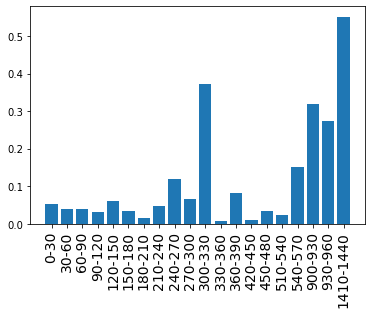

In [15]:
plot_frame(x_er, y_er)

**SlimBPR**

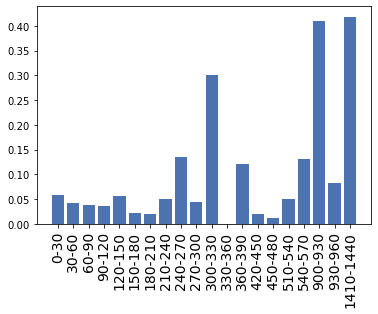

In [64]:
plot_frame(x_slb, y_slb)

**HybridLinear10**

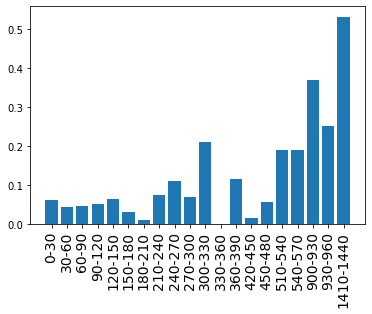

In [16]:
plot_frame(x_hl, y_hl)

**PageRankAlpha**

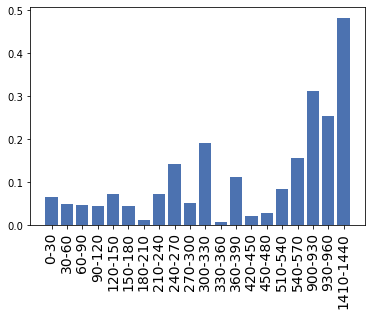

In [174]:
plot_frame(x_alph, y_alph)

**UserKNNCF**

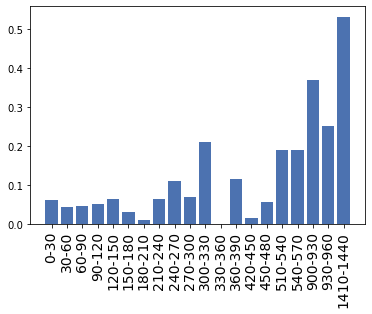

In [69]:
plot_frame(x_ucf, y_ucf)

**PureSVD**

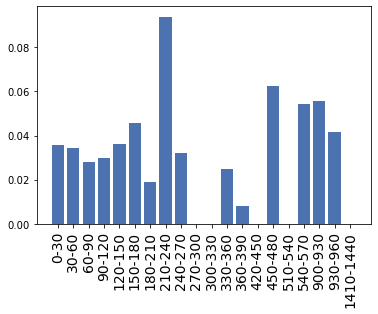

In [60]:
plot_frame(x_pp, y_pp)

**Matrix Factorization BPR**

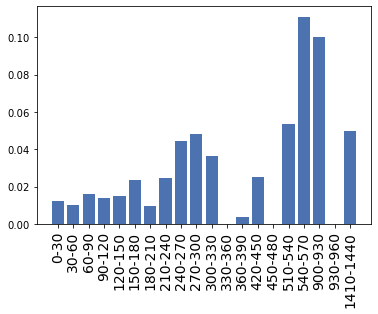

In [56]:
plot_frame(x_mf, y_mf)

#### ItemKNNCBF

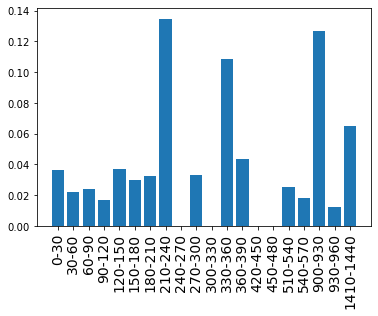

In [18]:
plot_frame(x_knn,y_knn)

#### ItemKNNCF

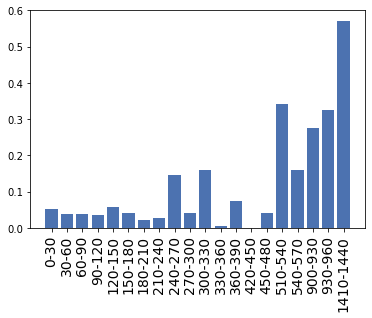

In [51]:
plot_frame(x_cf,y_cf)

#### SLIM ELASTICNET

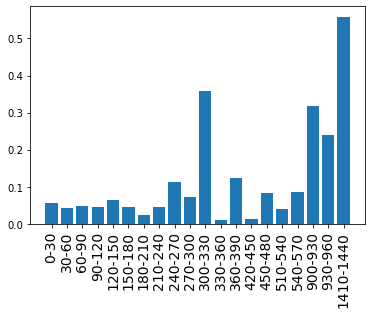

In [41]:
plot_frame(x_slim,y_slim)

#### PageRank

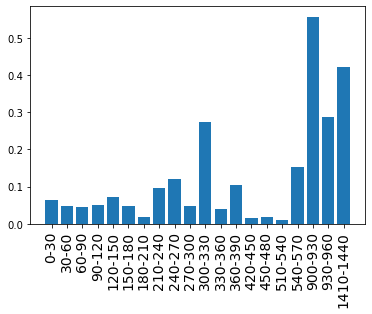

In [38]:
plot_frame(x_apr,y_apr)

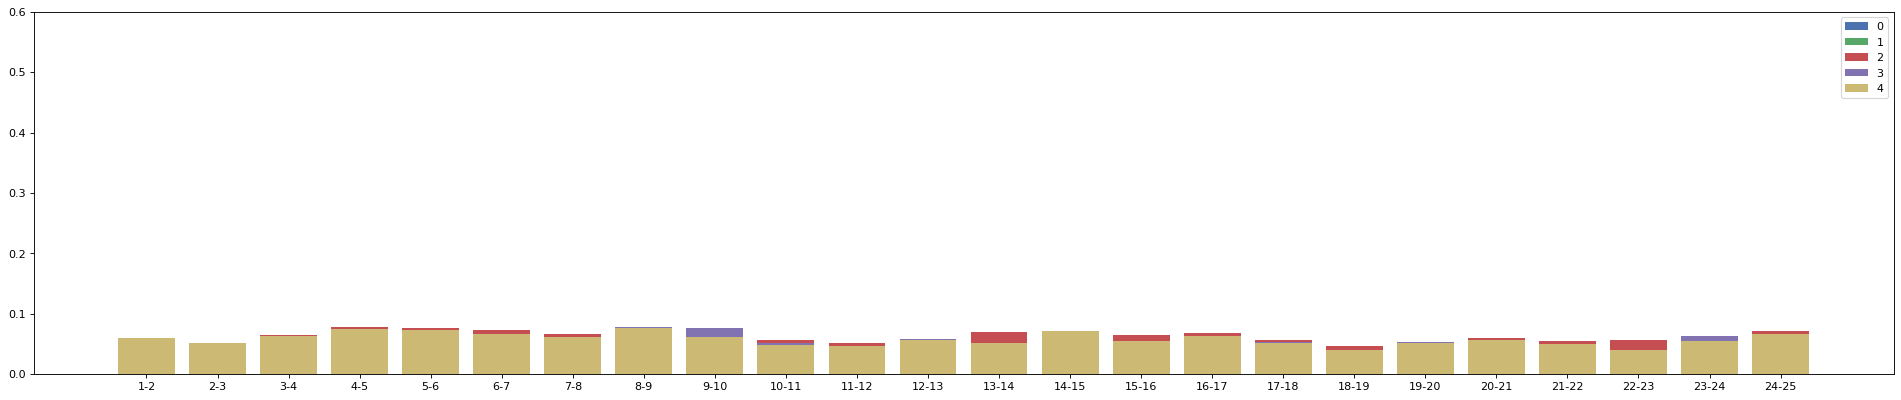

In [49]:
maps = [(x_mf, y_mf), (x_slim,y_slim), (x_cf,y_cf), (x_knn,y_knn), (x_apr,y_apr), (x_pp, y_pp), (x_slb, y_slb), (x_ucf, y_ucf), (x_alph, y_alph), (x_hl, y_hl)]
#maps = [(x_cf,y_cf), (x_knn,y_knn), (x_apr,y_apr), (x_slb, y_slb), (x_ucf, y_ucf)]
multiplot_frame(maps)

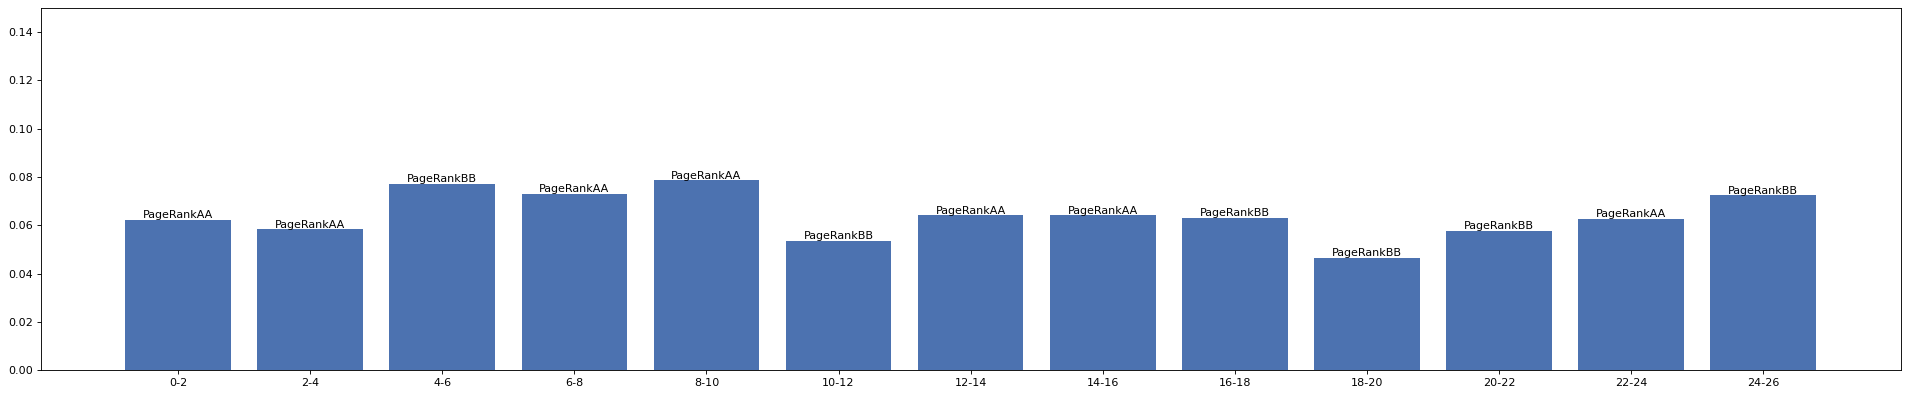

In [27]:
#maps = [(x_cf,y_cf), (x_knn,y_knn), (x_apr,y_apr), (x_slb, y_slb), (x_ucf, y_ucf), (x_pp, y_pp), (x_alph, y_alph), (x_mf, y_mf), (x_slim,y_slim)]
maps = [(x_cf,y_cf), (x_knn,y_knn), (x_apr,y_apr), (x_slb, y_slb), (x_ucf, y_ucf), (x_alph, y_alph)]
y_max, c = max_rec_map(maps)
maps = [(x_cf,y_max,c)]
multiplot_frame2(maps, ymax=0.15)

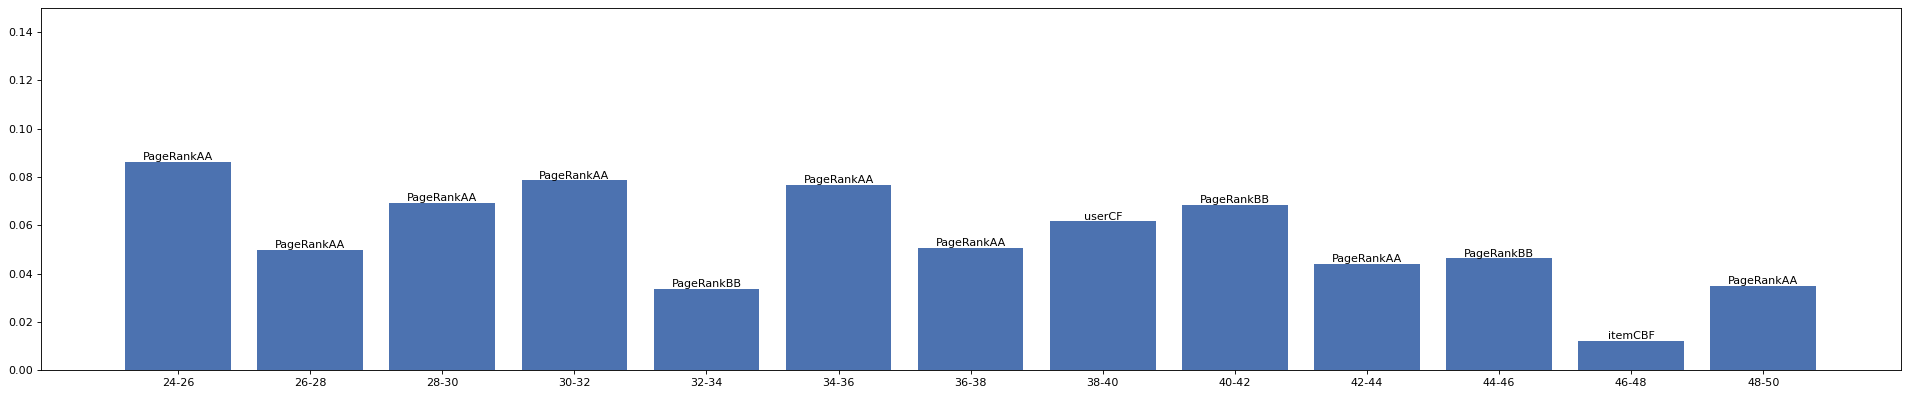

In [35]:
#maps = [(x_cf,y_cf), (x_knn,y_knn), (x_apr,y_apr), (x_slb, y_slb), (x_ucf, y_ucf), (x_pp, y_pp), (x_alph, y_alph), (x_mf, y_mf), (x_slim,y_slim)]
maps = [(x_cf,y_cf), (x_knn,y_knn), (x_apr,y_apr), (x_slb, y_slb), (x_ucf, y_ucf), (x_alph, y_alph)]
y_max, c = max_rec_map(maps)
maps = [(x_cf,y_max,c)]
multiplot_frame2(maps, ymax=0.15)

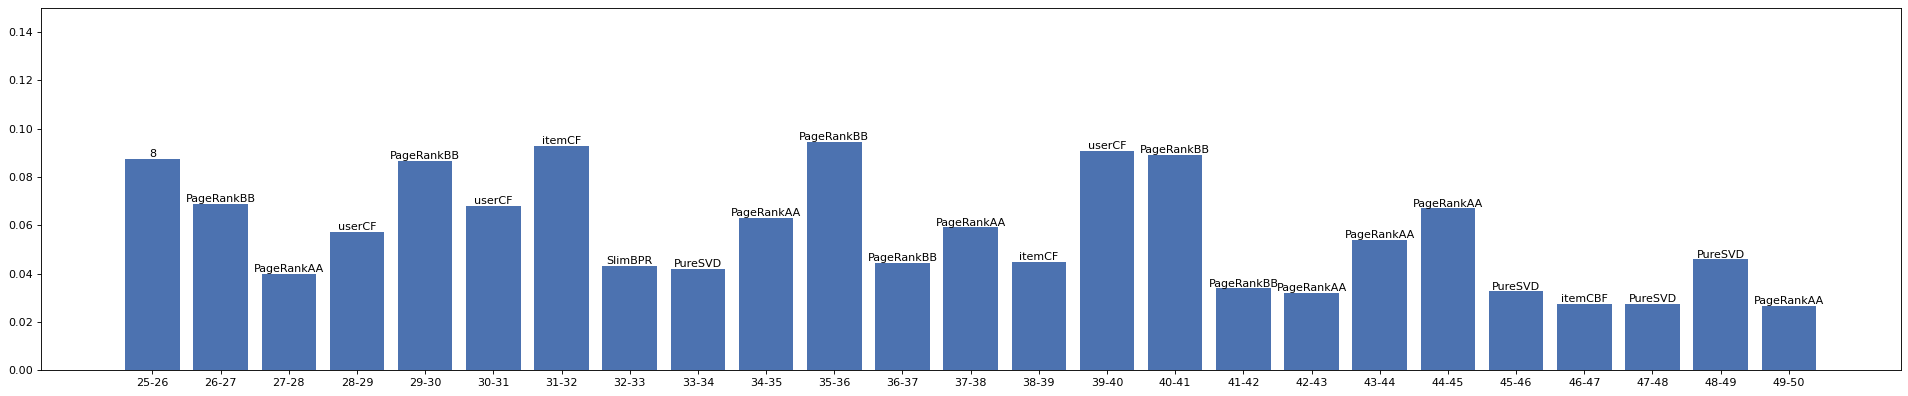

In [135]:
maps = [(x_cf,y_cf), (x_knn,y_knn), (x_apr,y_apr), (x_slb, y_slb), (x_ucf, y_ucf), (x_pp, y_pp), (x_alph, y_alph), (x_mf, y_mf), (x_slim,y_slim)]
#maps = [(x_cf,y_cf), (x_knn,y_knn), (x_apr,y_apr), (x_slb, y_slb), (x_ucf, y_ucf)]
y_max, c = max_rec_map(maps)
maps = [(x_cf,y_max,c)]
multiplot_frame2(maps, ymax=0.15)

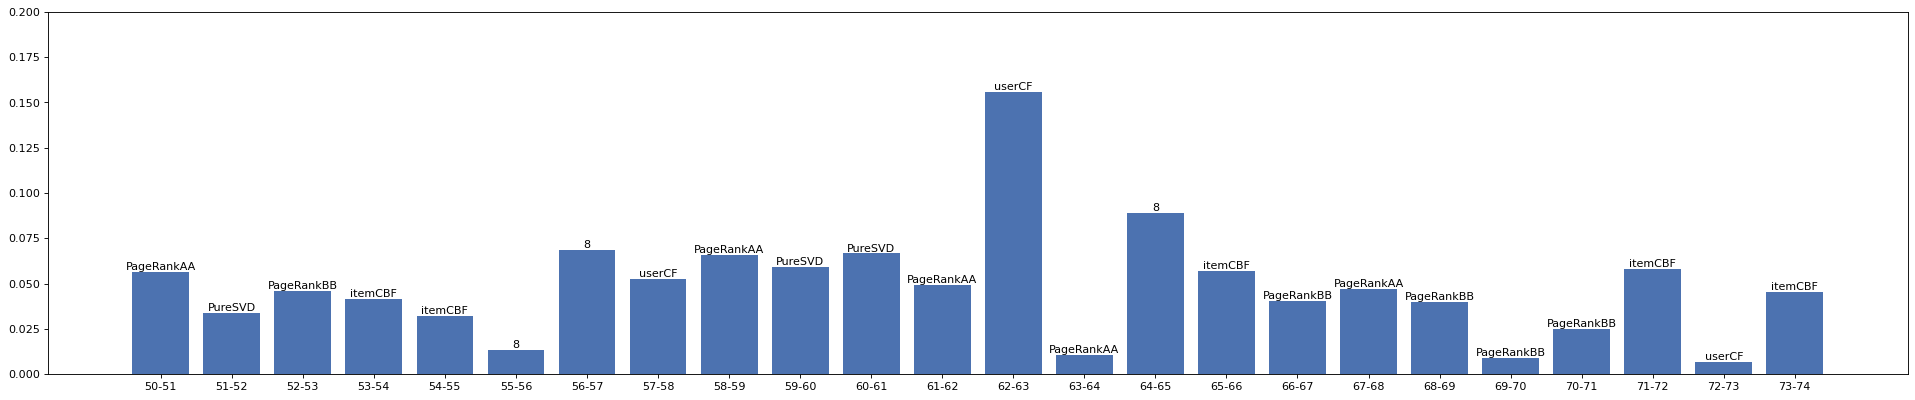

In [92]:
maps = [(x_cf,y_cf), (x_knn,y_knn), (x_apr,y_apr), (x_slb, y_slb), (x_ucf, y_ucf), (x_pp, y_pp), (x_alph, y_alph), (x_mf, y_mf), (x_slim,y_slim)]
#maps = [(x_cf,y_cf), (x_knn,y_knn), (x_apr,y_apr), (x_slb, y_slb), (x_ucf, y_ucf)]
y_max, c = max_rec_map(maps)
maps = [(x_cf,y_max,c)]
multiplot_frame2(maps, ymax=0.2)

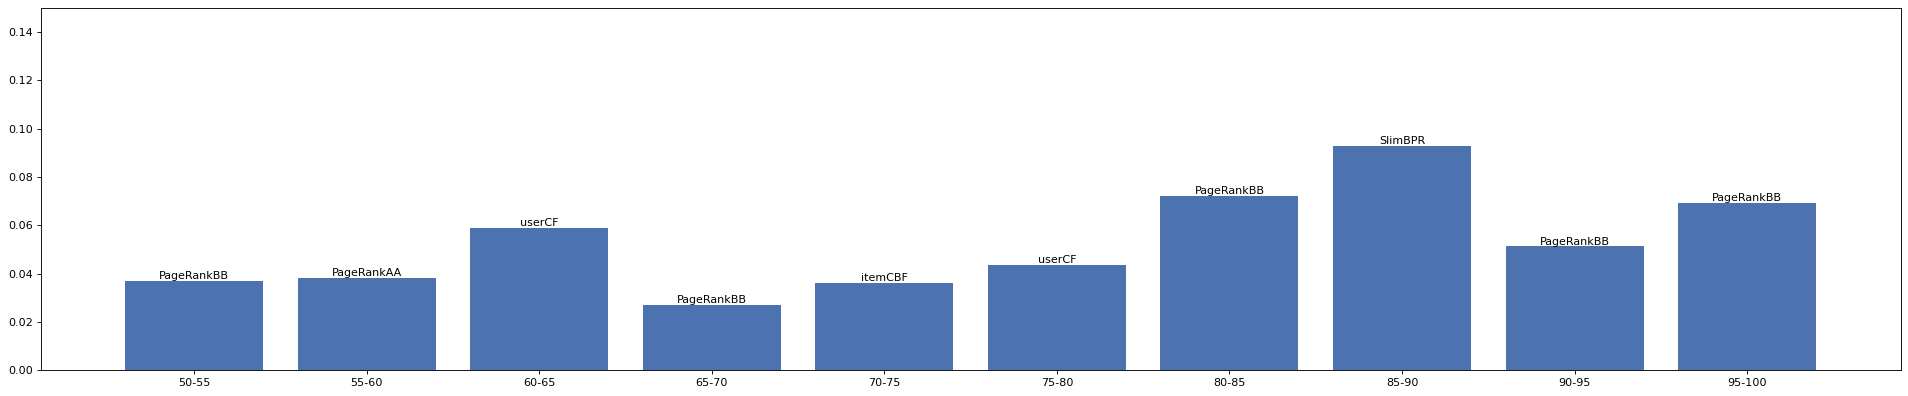

In [56]:
#maps = [(x_cf,y_cf), (x_knn,y_knn), (x_apr,y_apr), (x_slb, y_slb), (x_ucf, y_ucf), (x_pp, y_pp), (x_alph, y_alph), (x_mf, y_mf), (x_slim,y_slim)]
maps = [(x_cf,y_cf), (x_knn,y_knn), (x_apr,y_apr), (x_slb, y_slb), (x_ucf, y_ucf), (x_alph, y_alph)]
y_max, c = max_rec_map(maps)
maps = [(x_cf,y_max,c)]
multiplot_frame2(maps, ymax=0.15)

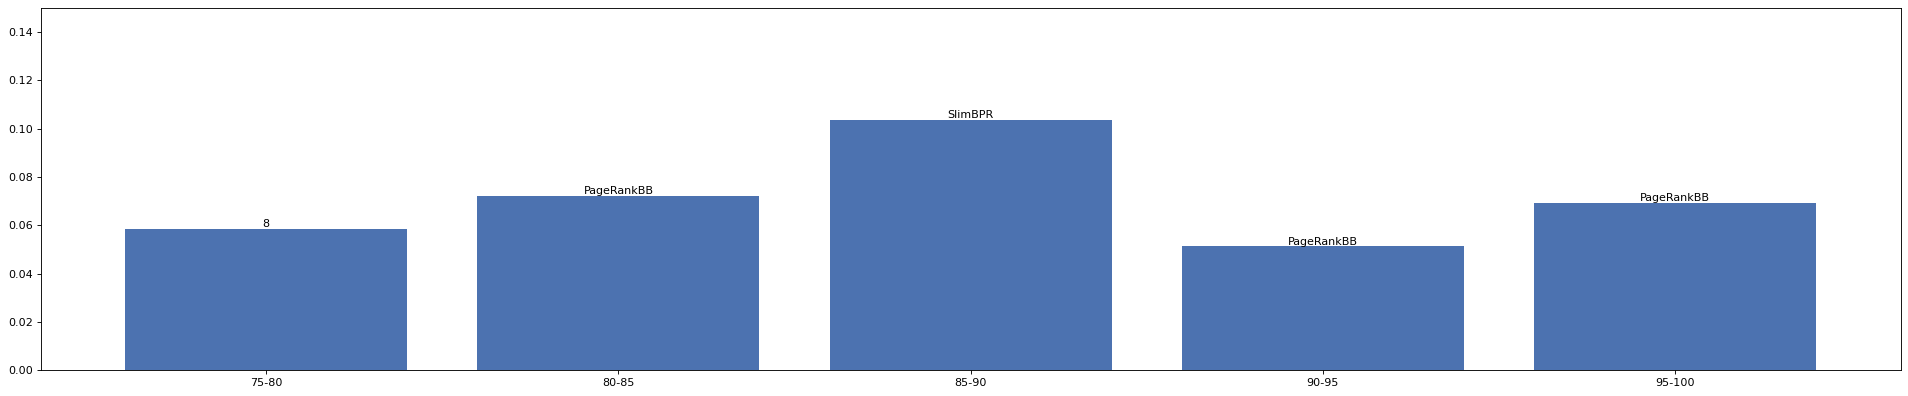

In [148]:
maps = [(x_cf,y_cf), (x_knn,y_knn), (x_apr,y_apr), (x_slb, y_slb), (x_ucf, y_ucf), (x_pp, y_pp), (x_alph, y_alph), (x_mf, y_mf), (x_slim,y_slim)]
#maps = [(x_cf,y_cf), (x_knn,y_knn), (x_apr,y_apr), (x_slb, y_slb), (x_ucf, y_ucf)]
y_max, c = max_rec_map(maps)
maps = [(x_cf,y_max,c)]
multiplot_frame2(maps, ymax=0.15)

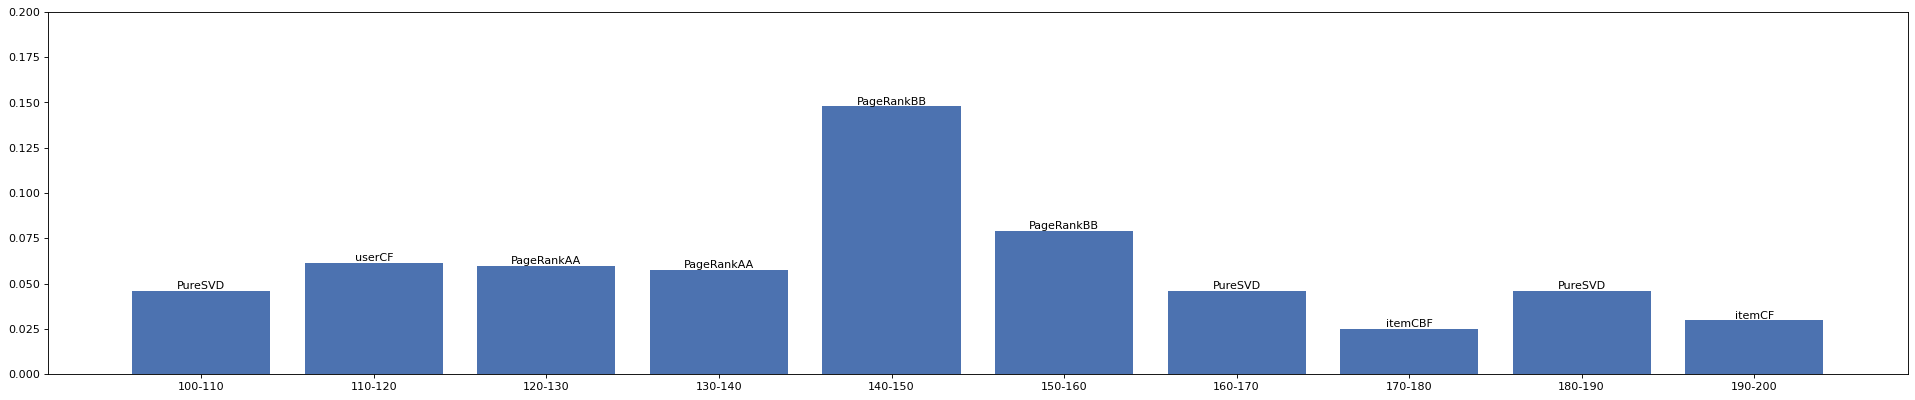

In [162]:
maps = [(x_cf,y_cf), (x_knn,y_knn), (x_apr,y_apr), (x_slb, y_slb), (x_ucf, y_ucf), (x_pp, y_pp), (x_alph, y_alph), (x_mf, y_mf), (x_slim,y_slim)]
#maps = [(x_cf,y_cf), (x_knn,y_knn), (x_apr,y_apr), (x_slb, y_slb), (x_ucf, y_ucf)]
y_max, c = max_rec_map(maps)
maps = [(x_cf,y_max,c)]
multiplot_frame2(maps, ymax=0.2)

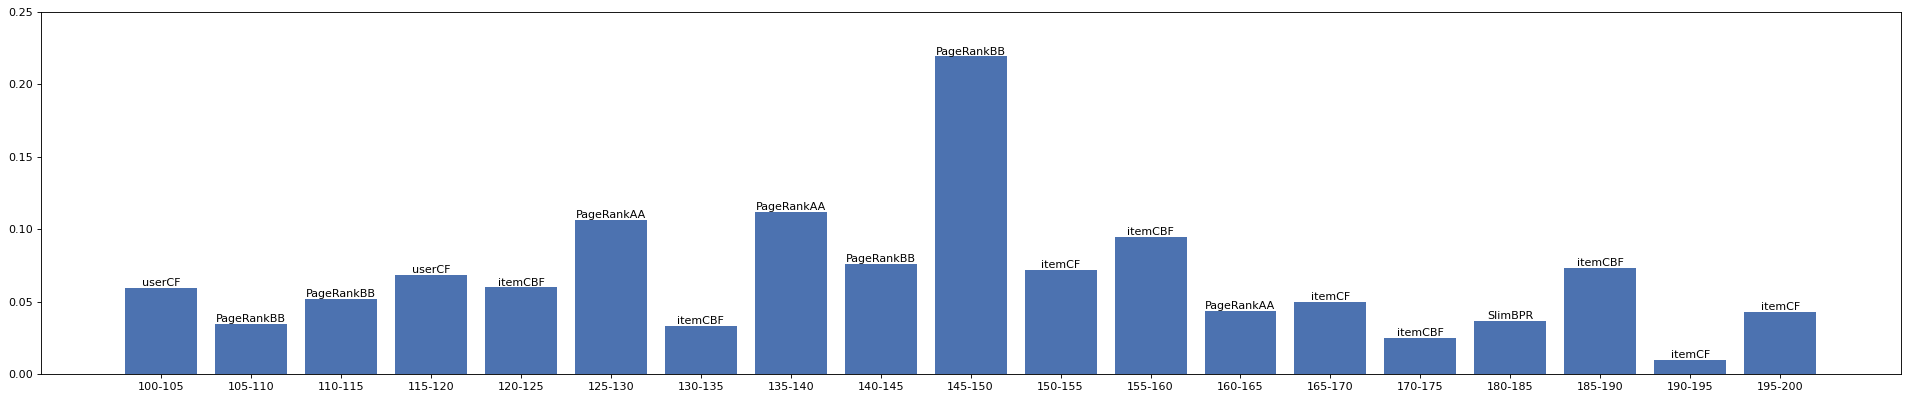

In [65]:
#maps = [(x_cf,y_cf), (x_knn,y_knn), (x_apr,y_apr), (x_slb, y_slb), (x_ucf, y_ucf), (x_pp, y_pp), (x_alph, y_alph), (x_mf, y_mf), (x_slim,y_slim)]
maps = [(x_cf,y_cf), (x_knn,y_knn), (x_apr,y_apr), (x_slb, y_slb), (x_ucf, y_ucf), (x_alph, y_alph)]
y_max, c = max_rec_map(maps)
maps = [(x_cf,y_max,c)]
multiplot_frame2(maps, ymax=0.25)

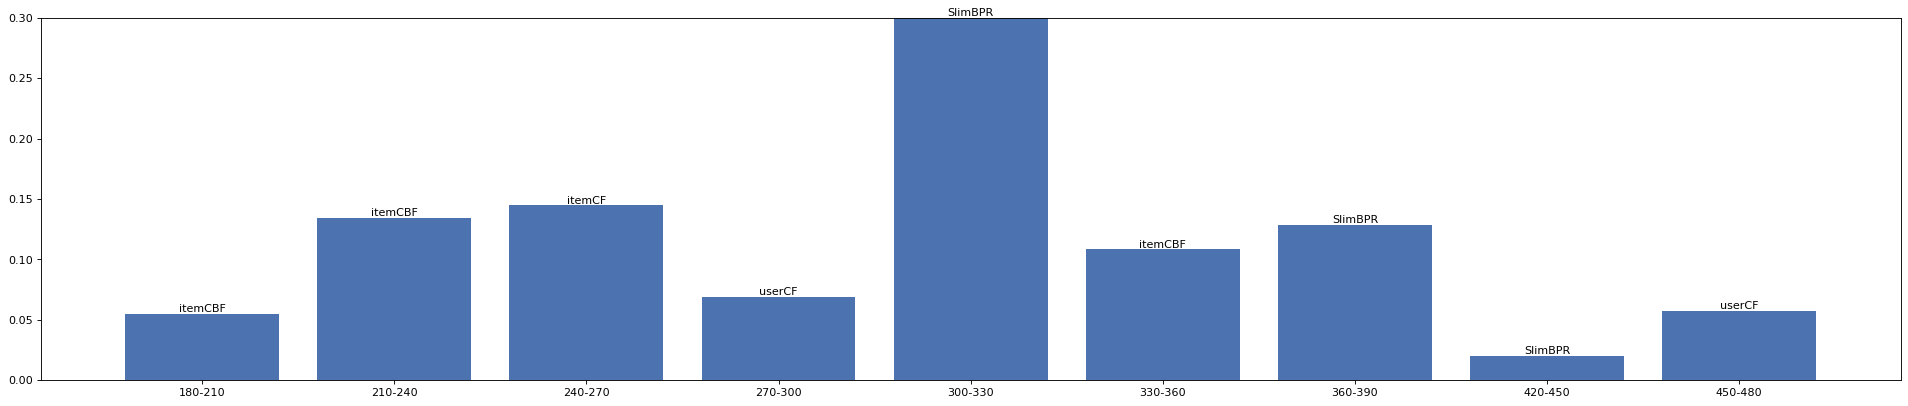

In [232]:
maps = [(x_cf,y_cf), (x_knn,y_knn), (x_apr,y_apr), (x_slb, y_slb), (x_ucf, y_ucf), (x_pp, y_pp), (x_alph, y_alph)]#, (x_mf, y_mf), (x_slim,y_slim)]
#maps = [(x_cf,y_cf), (x_knn,y_knn), (x_apr,y_apr), (x_slb, y_slb), (x_ucf, y_ucf)]
y_max, c = max_rec_map(maps)
maps = [(x_cf,y_max,c)]
multiplot_frame2(maps, ymax=0.3)

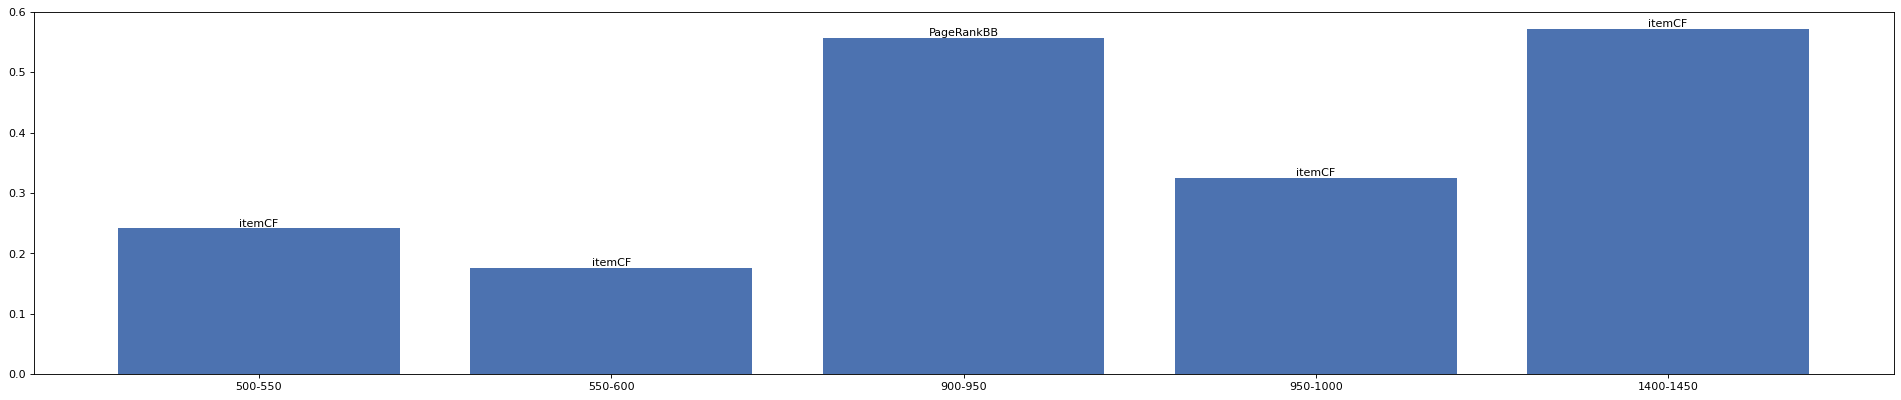

In [189]:
maps = [(x_cf,y_cf), (x_knn,y_knn), (x_apr,y_apr), (x_slb, y_slb), (x_ucf, y_ucf), (x_pp, y_pp), (x_alph, y_alph), (x_slim,y_slim)]
#maps = [(x_cf,y_cf), (x_knn,y_knn), (x_apr,y_apr), (x_slb, y_slb), (x_ucf, y_ucf)]
y_max, c = max_rec_map(maps)
maps = [(x_cf,y_max,c)]
multiplot_frame2(maps, ymax=0.6)

In [63]:
result_eval, _ = evaluator_test.evaluateRecommender(rec1)
result_eval[10]['MAP']

EvaluatorHoldout: Processed 5002 ( 100.00% ) in 2.67 sec. Users per second: 1871


0.03492096280031698

In [65]:
result_eval, _ = evaluator_test.evaluateRecommender(rec_elasticnet)
result_eval[10]['MAP']

EvaluatorHoldout: Processed 5002 ( 100.00% ) in 2.94 sec. Users per second: 1704


0.05483607952006887

In [19]:
result_eval, _ = evaluator_test.evaluateRecommender(recommender_apr)
result_eval[10]['MAP']

EvaluatorHoldout: Processed 5002 ( 100.00% ) in 2.67 sec. Users per second: 1871


0.06227232563764613

---

#### Testing the `filter_URM_test_by_range` function

In [7]:
from DataParser import DataParser
import numpy as np
import pandas as pd
import scipy.sparse as sp

from Base.Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import \
split_train_in_two_percentage_global_sample

In [8]:
seed = 1024
parser = DataParser()
URM_train, URM_test = split_train_in_two_percentage_global_sample(parser.get_URM_all(),train_percentage=0.85, seed=seed)

In [9]:
new_urm_test = parser.filter_URM_test_by_range(URM_train, URM_test, filter_range=(1,2))

In [10]:
new_urm_test = parser.filter_URM_test_by_range(URM_train, URM_test, filter_range=(1000,-1))

In [5]:
new_urm_test = parser.filter_URM_test_by_range(URM_train, URM_test, filter_range=(0,1))

AssertionError: There are no user in the selected range.

In [6]:
new_urm_test = parser.filter_URM_test_by_range(URM_train, URM_test, filter_range=(1,1))

AssertionError: Invalid filter range.

In [6]:
new_urm_test = parser.filter_URM_test_by_range(URM_train, URM_test, filter_range=(0,-1))

In [11]:
URM_train, URM_test = split_train_in_two_percentage_global_sample(parser.get_URM_all(), train_percentage=0.85, seed=seed)

In [12]:
n_URM_test = parser.filter_URM_test_by_range(URM_train, URM_test, (0,2))
evaluator_test = EvaluatorHoldout(n_URM_test, cutoff_list=[10])

In [13]:
from GraphBased.P3alphaRecommender import P3alphaRecommender
recommender_alph = P3alphaRecommender(URM_train)
recommender_alph.fit(alpha=0.4905425214201532, topK=1000, normalize_similarity=False)


P3alphaRecommender: URM Detected 42 (0.53 %) cold users.
P3alphaRecommender: URM Detected 1971 (7.59 %) cold items.


In [14]:
evaluator_test.evaluateRecommender(recommender_alph)

EvaluatorHoldout: Processed 335 ( 100.00% ) in 0.18 sec. Users per second: 1812


({10: {'ROC_AUC': 0.09216417910447763,
   'PRECISION': 0.013432835820895522,
   'PRECISION_RECALL_MIN_DEN': 0.11343283582089553,
   'RECALL': 0.11343283582089553,
   'MAP': 0.06216003316749585,
   'MRR': 0.07094290452499406,
   'NDCG': 0.07657123750715114,
   'F1': 0.02402107111501317,
   'HIT_RATE': 0.13432835820895522,
   'ARHR': 0.07168917318171049,
   'NOVELTY': 0.005150645204157994,
   'AVERAGE_POPULARITY': 0.0706862085966564,
   'DIVERSITY_MEAN_INTER_LIST': 0.9837322370185003,
   'DIVERSITY_HERFINDAHL': 0.9980795722878146,
   'COVERAGE_ITEM': 0.0806929740134745,
   'COVERAGE_ITEM_CORRECT': 0.001693936477382098,
   'COVERAGE_USER': 0.0421542720523468,
   'COVERAGE_USER_CORRECT': 0.005536680508367938,
   'DIVERSITY_GINI': 0.05325935766195202,
   'SHANNON_ENTROPY': 10.382128701432213}},
 'CUTOFF: 10 - ROC_AUC: 0.0921642, PRECISION: 0.0134328, PRECISION_RECALL_MIN_DEN: 0.1134328, RECALL: 0.1134328, MAP: 0.0621600, MRR: 0.0709429, NDCG: 0.0765712, F1: 0.0240211, HIT_RATE: 0.1343284, A

In [15]:
recommender_alph.fit(alpha=0.7369378837701063, topK=433, normalize_similarity=False) #'topK': 999, 'alpha': 0.017149898389464017, 'normalize_similarity': True
evaluator_test.evaluateRecommender(recommender_alph)

EvaluatorHoldout: Processed 335 ( 100.00% ) in 0.21 sec. Users per second: 1593


({10: {'ROC_AUC': 0.09183250414593701,
   'PRECISION': 0.013432835820895522,
   'PRECISION_RECALL_MIN_DEN': 0.11343283582089553,
   'RECALL': 0.11343283582089553,
   'MAP': 0.06147773039564084,
   'MRR': 0.0700722577588249,
   'NDCG': 0.07598219144700179,
   'F1': 0.02402107111501317,
   'HIT_RATE': 0.13432835820895522,
   'ARHR': 0.07081852641554132,
   'NOVELTY': 0.0052298198195768406,
   'AVERAGE_POPULARITY': 0.054666308099143954,
   'DIVERSITY_MEAN_INTER_LIST': 0.98584502636518,
   'DIVERSITY_HERFINDAHL': 0.9982902205390956,
   'COVERAGE_ITEM': 0.0851973051010587,
   'COVERAGE_ITEM_CORRECT': 0.001693936477382098,
   'COVERAGE_USER': 0.0421542720523468,
   'COVERAGE_USER_CORRECT': 0.005536680508367938,
   'DIVERSITY_GINI': 0.0588675884513374,
   'SHANNON_ENTROPY': 10.538661194079546}},
 'CUTOFF: 10 - ROC_AUC: 0.0918325, PRECISION: 0.0134328, PRECISION_RECALL_MIN_DEN: 0.1134328, RECALL: 0.1134328, MAP: 0.0614777, MRR: 0.0700723, NDCG: 0.0759822, F1: 0.0240211, HIT_RATE: 0.1343284, AR